# Проект "Телеком". Предсказание оттока клиентов

# Загрузка данных

## Загрузка библиотек

In [8]:
!pip install -q phik
!pip install --upgrade -q scikit-learn
!pip install -q category_encoders
!pip install -q catboost
!pip install -q lightgbm
!pip install -q scikit-plot
!pip uninstall -y psycopg2 psycopg2-binary
!pip install psycopg2-binary

  Using cached psycopg2-binary-2.9.10.tar.gz (385 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for psycopg2-binary: filename=psycopg2_binary-2.9.10-cp38-cp38-macosx_10_9_x86_64.whl size=143499 sha256=0237bb2f2728e66c3244daec3a5227f5088f99b95ceddbf4b1f02d1c0e672862
  Stored in directory: /Users/lena/Library/Caches/pip/wheels/df/fb/7d/c43b1faf8e1ae26e14d1e183eca11ef5560125067a34948080
Successfully built psycopg2-binary


In [7]:
!brew install postgresql

Running `brew update --auto-update`...
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:0c78b38f22fb9b42df6918db00e6f5a80d5b35164f910ffe4c89159326ae98cf
######################################################################### 100.0%#########################################                     74.9%
==> Pouring portable-ruby-3.4.5.el_capitan.bottle.tar.gz
==> Fetching downloads for: postgresql@14
==> Downloading https://ghcr.io/v2/homebrew/core/postgresql/14/manifests/14.18
######################################################################### 100.0%
==> Fetching dependencies for postgresql@14: icu4c@77, ca-certificates, openssl@3, krb5, lz4 and readline
==> Downloading https://ghcr.io/v2/homebrew/core/icu4c/77/manifests/77.1
######################################################################### 100.0%
==> Fetching icu4c@77
==> Downloading https://ghcr.io/v2/homebrew/core/icu4c/77/blobs/sha256:54d609feb
#########################################

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report

import scikitplot as skplt
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, PrecisionRecallDisplay

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sqlalchemy import create_engine

import pickle

import warnings
warnings.filterwarnings('ignore')

# Зададим глобальную переменную RANDOM_STATE
RANDOM_STATE = 100624

## Подключение к базе данных

Подключимся к базе данных.

In [10]:
db_config = {
'user': 'praktikum_student',# имя пользователя,
'pwd': 'Sdf4$2;d-d30pp',# пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения,
'db': 'data-science-final'# название базы данных,
}

In [11]:
# Создадим подключение к базе данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

In [12]:
# Создадим соединение
engine = create_engine(connection_string)

In [13]:
# Создадим пробный запрос
query = '''
SELECT "BeginDate"
FROM telecom.contract;
'''
pd.read_sql_query(query, con=engine).head(5)

,BeginDate
0,2020-02-01
1,2020-02-01
2,2018-08-09
3,2020-02-01
4,2019-01-26


# Исследовательский анализ и предобработка данных

* **Проанализируйте исходные данные. Проверьте:**

    * Все ли таблицы содержат данные.
    * Соответствует ли количество таблиц условию задачи.

* **Для каждой таблицы:**
  
    * Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
    * Обработайте аномалии с учётом особенностей услуг телекоммуникации.

Проверим количество таблиц в базе данных

In [14]:
query = '''
SELECT table_name
  FROM information_schema.tables
 WHERE table_schema NOT IN ('information_schema','pg_catalog');
'''
df = pd.read_sql_query(query, con=engine)
df

,table_name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_gas
4,data_temp
5,data_wire
6,data_wire_time
7,contract
8,internet
9,personal


Нужные нам таблице есть в базе: contract, internet, personal, phone.  
Далее загрузим каждую таблицу по-отдельности и познакомимся с их содержимым.

Загрузим таблицу **telecom.contract** c информацией о договорах клиентов

In [15]:
query = '''
SELECT *
FROM telecom.contract;
'''
telecom_contract_data = pd.read_sql_query(query, con=engine)
telecom_contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [16]:
telecom_contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


**Таблица telecom.contract**

* customerID — ID абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

В таблице telecom.contract 8 столбцов, 7043 строки/договоров.

Внесем некоторые измнения:
* Приведение названий признаков датафрейма к "змеиному стилю".     
* Заменим тип данных BeginDate и EndDate c object на date.   

In [17]:
# Приведение названий признаков датафрейма к "змеиному стилю"
telecom_contract_data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in telecom_contract_data.columns]
telecom_contract_data = telecom_contract_data.rename(columns={'customer_i_d':'customer_id'})

# Проверка полученных названий
telecom_contract_data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [18]:
# Проверим корректность внесенных изменений
telecom_contract_data.dtypes

customer_id           object
begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
dtype: object

Проверим данные на наличие пропущенных значений.

In [19]:
telecom_contract_data.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

* В колонке end_date - 5174 пропусков.
* В колонке total_charges - 11 пропусков



Проверим строки, в которых есть пропуски в колонке 'total_charges'

In [20]:
# Фильтрация строк, где в колонке 'total_charges' есть NaN
missing_total_charges = telecom_contract_data[telecom_contract_data['total_charges'].isna()]
missing_total_charges

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


Если посмотреть на колонки begin_date	и end_date, то мы увидим, что все даты  равны дате вырузки базы 2020-02-01. То есть это клиенты, только что открывшие договор и у них еще нет расходов.

Поэтому поставим значение 0 в строки с пропусками.

In [21]:
# Заполнение пропусков в поле 'total_charges' на 0. Эти клиенты еще не успели внести плату
telecom_contract_data['total_charges'] = telecom_contract_data['total_charges'].fillna(0)

Выделим в целевую переменную признак end_date.

Целевой переменной в нашем исследовании является признак - разорвал ли клиент договор с телекоммуникационной компанией (0- нет, 1 - да).

Если значение в колонке 'end_date' равно None, это будет означать, что договор еще не расторгнут.

In [22]:
def contract_terminated(end_date):
    if end_date is None:  # Если дата окончания не указана, то договор действует
        return 0
    else:
        return 1  # Иначе договор разорван

telecom_contract_data['contract_terminated'] = telecom_contract_data['end_date'].apply(contract_terminated)

telecom_contract_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_terminated
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,0.00,0
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,0.00,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,0.00,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Далее заполним пропуски в колонке 'end_date'.
Предположим, что пропуски в 'end_date' связаны с тем, что клиенты еще не закрыли договор с компанией, это действующие клиенты. Поэтому поставим заглушку в виде даты вырузки базы 2020-02-01 (т.к. информация о договорах актуальна на 1 февраля 2020).

In [23]:
telecom_contract_data['end_date'] = telecom_contract_data['end_date'].fillna('2020-02-01')

In [24]:
# Поменять тип данных BeginDate и EndDate c object на date
telecom_contract_data['begin_date'] = pd.to_datetime(telecom_contract_data['begin_date'], format='%Y-%m-%d')
telecom_contract_data['end_date'] = pd.to_datetime(telecom_contract_data['end_date'], format='%Y-%m-%d')

In [25]:
telecom_contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   datetime64[ns]
 3   type                 7043 non-null   object        
 4   paperless_billing    7043 non-null   object        
 5   payment_method       7043 non-null   object        
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   contract_terminated  7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [26]:
telecom_contract_data.isna().sum()

customer_id            0
begin_date             0
end_date               0
type                   0
paperless_billing      0
payment_method         0
monthly_charges        0
total_charges          0
contract_terminated    0
dtype: int64

Избавились от пропусков в таблице telecom_contract_data.
Проверим данные на явные дубликаты.

In [27]:
telecom_contract_data.duplicated().sum()

0

Дублей нет.  
Посмотрим более подробную информацию о числовых данных в таблице telecom_contract_data с помощью метода describe().  

In [28]:
num_col = ['monthly_charges', 'total_charges']
telecom_contract_data[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


* Средние месячные траты (monthly_charges) клиентов равны 64.76. Min месячные расходы 18.25, а максимальные - 118.75.
* Средние общие траты клиентов равны 2279.73. Min расходы 0, а максимальные - 8684.80.

Построим дополнительно графики - гистограммы.

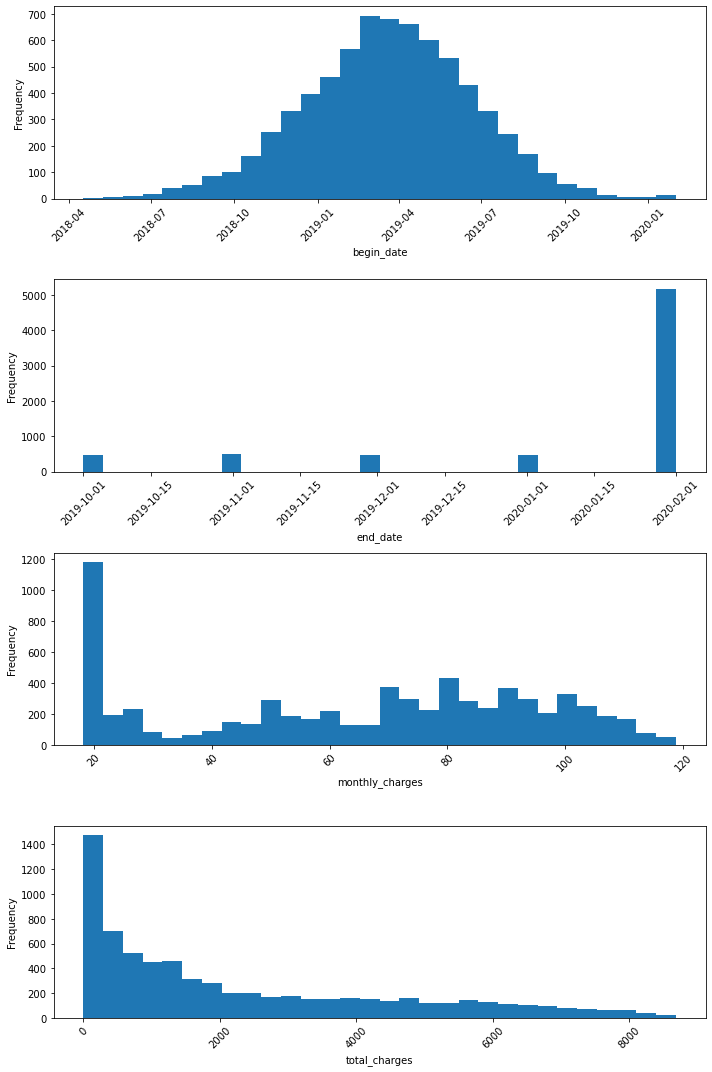

In [29]:
col = ['begin_date', 'end_date', 'monthly_charges', 'total_charges']

fig, axes = plt.subplots(nrows=len(col), figsize=(10, 15))

# Поворот меток по оси X под углом 45 градусов и добавление подписи осей
for i, ax in enumerate(axes):
    ax.hist(telecom_contract_data[col[i]], bins=30)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(col[i])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

* У нас есть исторические данные о клиентах за период с 2018-04 по 2020-01.
Большее количество клиентов заключило договора ('begin_date') в период 2019-03 - 2019-05.
* Большее количесвто клиентов в базе активны и имеют действующие договора (у таких клиентов в колонке 'end_date' значения равны дате выгрузки базы 2020-02-01). Остальные клиенты примерно в равной степени закрывали договора: 2019-10, 2019-11, 2019-12, 2020-01.
* Большая часть клиентов имеют довольно маленькие ежемесячные траты 'monthly_charges' от 15-22.
* Большая часть клиентов имеют общие траты 'total_charges' до 500.


Построим столбчатые графики для категориальных значений (бинарных значений): 'type', 'payment_method', 'paperless_billing'.

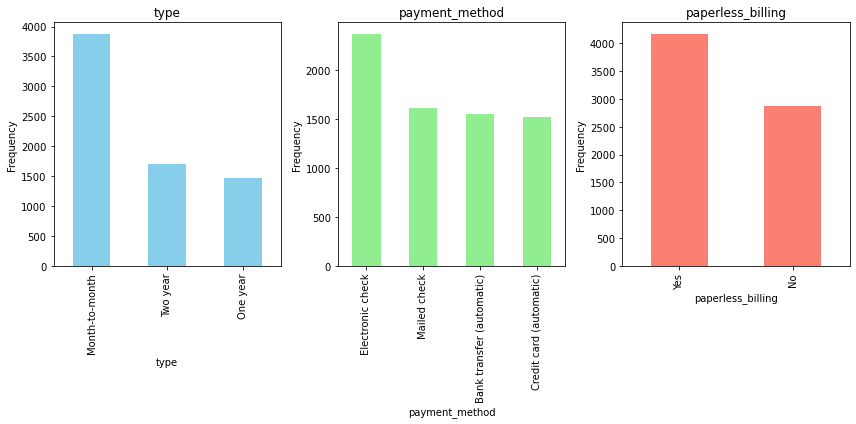

In [30]:
# Список колонок для построения графиков
columns_to_plot = ['type', 'payment_method', 'paperless_billing']
titles = ['type', 'payment_method', 'paperless_billing']
colors = ['skyblue', 'lightgreen', 'salmon']

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Цикл для создания столбчатых диаграмм
for ax, column, title, color in zip(axes.flatten(), columns_to_plot, titles, colors):
    telecom_contract_data[column].value_counts().plot(kind='bar', ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

* Большинство клиентов имеют ежемесячный тип оплаты 'type', прочие примерно в равной степени раз в год или два.
* Большинство клиентов предпочитают расплачиваться 'payment_method' за услуги электронными чеками, остальные примерно в равной степени через почтовые чеки, авто-банковские переводы или автоматические платежи кредитной картой.
* Большинство клиентов имеют электронный расчётный лист 'paperless_billing'.

Теперь выгрузим таблицу с персональными данными клиентов **telecom.personal**.


In [31]:
query = '''
SELECT *
FROM telecom.personal;
'''
telecom_personal_data = pd.read_sql_query(query, con=engine)
telecom_personal_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [32]:
telecom_personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Таблица telecom.personal**

* customerID — ID пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

В датасете telecom_personal_data 5 столбцов и 7043 строк/клиентов, что равно количеству строк/договоров в предыдущей таблице telecom_contract_data.

Пропущенных значений нет.

Внесем несколько изменений в данные:

* Приведение названий признаков датафрейма к "змеиному стилю"

In [33]:
# Приведение названий признаков датафрейма к "змеиному стилю"
telecom_personal_data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in telecom_personal_data.columns]
telecom_personal_data = telecom_personal_data.rename(columns={'customer_i_d':'customer_id'})

# Проверка полученных названий
telecom_personal_data.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Проверим датасет на явные дубликаты

In [34]:
telecom_personal_data.duplicated().sum()

0

Явных дублей нет.

Построим столбчатые графики для категориальных значений (бинарных в том числе).

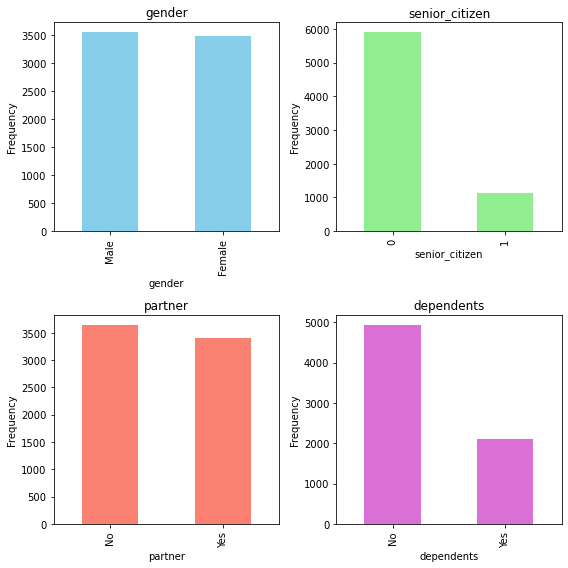

In [35]:
# Список колонок для построения графиков
columns_to_plot = ['gender', 'senior_citizen', 'partner', 'dependents']
titles = ['gender', 'senior_citizen', 'partner', 'dependents']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid']

# Настройка фигуры и подграфиков
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Цикл для создания столбчатых диаграмм
for ax, column, title, color in zip(axes.flatten(), columns_to_plot, titles, colors):
    telecom_personal_data[column].value_counts().plot(kind='bar', ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

* В датасете практически равное количество клиентов мужчин и женщин ('gender').
* Большинство клиентов не пенсионеры (значение в колонке 'senior_citizen' - 0)
* В датасете практически равное количество женатых и холостых клиентов, колонка 'partner' (холостых чуть больше)
* Большинство клиентов 'dependents' без детей


Выгрузим таблицу **telecom.internet** с информацией об интернет-услугах.

In [36]:
query = '''
SELECT *
FROM telecom.internet;
'''
telecom_internet_data = pd.read_sql_query(query, con=engine)
telecom_internet_data.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


Сразу удалим названия столбцов c1-c8, поставим понятные названия: 'customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'.

In [37]:
# Выбираем строки начиная с первой (индекс 1) и все столбцы
telecom_internet_data = telecom_internet_data.iloc[1:, :].reset_index(drop=True)
telecom_internet_data.columns = ['customerID', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
telecom_internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [38]:
telecom_internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Таблица telecom.internet**

* customerID — ID пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.


Значений/клиентов меньше, чем в предыдущих таблицах - 5517 вместо 7043. Это говорит о том, что не все клиенты пользуются интернет-услугами компании.

Пропущенных значений в датасете нет.

Внесем некоторые изменения в данные:

* Приведение названий признаков датафрейма к "змеиному стилю"
* Заменим значения Yes/No в колонках 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies' на 1/0.


In [39]:
# Приведение названий признаков датафрейма к "змеиному стилю"
telecom_internet_data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in telecom_internet_data.columns]
telecom_internet_data = telecom_internet_data.rename(columns={'customer_i_d':'customer_id'})

# Проверка полученных названий
telecom_internet_data.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object')

Проверим данные на явные дубли.

In [40]:
telecom_internet_data.duplicated().sum()

0

Явных дублей нет.  
Построим столбчатые диаграмы для категориальных значений (в том числе и для бинарных).

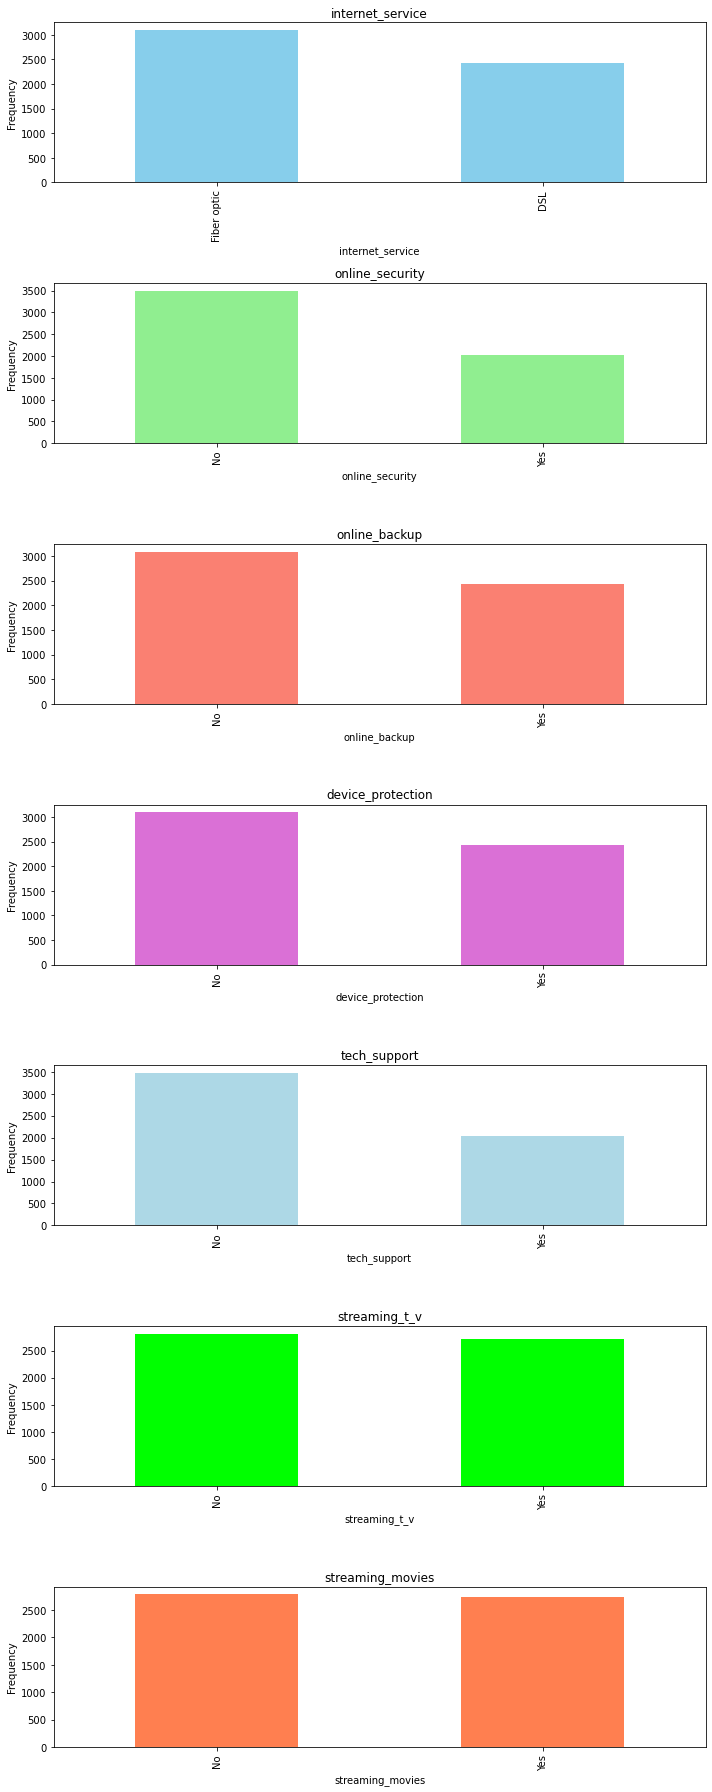

In [41]:
# Список колонок для построения графиков
columns_to_plot = ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies']
titles = ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'lightblue', 'lime', 'coral']

# Настройка фигуры и подграфиков
fig, axes = plt.subplots(7, 1, figsize=(10, 25))

# Цикл для создания столбчатых диаграмм
for ax, column, title, color in zip(axes.flatten(), columns_to_plot, titles, colors):
    telecom_internet_data[column].value_counts().plot(kind='bar', ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

* У большинства клиентов тип интернет-подключения 'internet_service' - fiber optic.
* Большинство клиентов не подключали опцию блокировка опасных сайтов 'online_security'.
* Большинство клиентов не подключали опцию - облачное хранилище файлов для резервного копирования данных 'online_backup'
* Большинство клиентов не подключали опцию антивирус 'device_protection'
* Большинство клиентов не подключали опцию выделенная линия технической поддержки 'tech_support'
* Примерно одинаковое количество клиентов пользуются/не пользуются стриминговым телевидением 'streaming_t_v'
* Примерно одинаковое количество клиентов пользуются/не пользуются каталогом фильмов 'streaming_movies'

Загрузим последнюю таблицу с информацией об услугах телефонии **telecom.phone**

In [42]:
query = '''
SELECT *
FROM telecom.phone;
'''
telecom_phone_data = pd.read_sql_query(query, con=engine)
telecom_phone_data.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


Сразу удалим названия столбцов c1-c2, чтобы оставить понятные названия: 'customerID', 'MultipleLines'.

In [43]:
# Выбираем строки начиная с первой (индекс 1) и все столбцы
telecom_phone_data = telecom_phone_data.iloc[1:, :].reset_index(drop=True)
telecom_phone_data.columns = ['customerID', 'MultipleLines']
telecom_phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [44]:
telecom_phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Таблица **telecom_phone_data**:

* customerID — ID пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

В датасете 2 колонки и 6361 строка - меньше, чем в таблице с договорами telecom.contract и персональными данными telecom.personal, это говорит о том, что не все клиенты подключали услуги телефонии.

Пропущенных значений в датасете нет.

Внесем некоторые изменения в данные:

* Приведение названий признаков датафрейма к "змеиному стилю"

In [45]:
telecom_phone_data.rename(columns={'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'}, inplace=True)
telecom_phone_data.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Проверим датасет на явные дубликаты.

In [46]:
telecom_phone_data.duplicated().sum()

0

Явных дублей нет.
Построим столбчатый график для категориальных значений

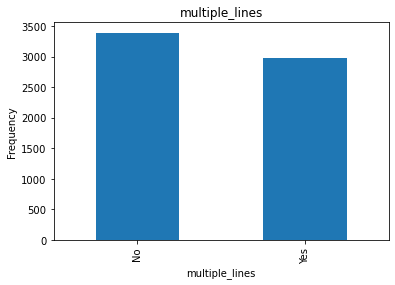

In [47]:
plt.figure(figsize=(6, 4))
telecom_phone_data['multiple_lines'].value_counts().plot(kind='bar')
plt.title('multiple_lines')
plt.xlabel('multiple_lines')
plt.ylabel('Frequency')
plt.show()

Большинство клиентов не подключали телефоны к нескольким линиям одновременно.

## Объединение таблиц

* **Объедините таблицы по ID клиента:**
  
    * Каждому клиенту должно соответствовать одно наблюдение. При объединении учитывайте особенности услуг телекоммуникации.

    * Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении. Например, рассчитайте длительность контракта абонента.
    * Выделите в целевую переменную признак EndDate.
    * Проведите исследовательский анализ данных объединённой таблицы, при необходимости заполните пропуски и визуализируйте распределение каждого признака.
    * Визуализируйте соотношение ушедших и оставшихся клиентов для каждого признака.
    * Проведите корреляционный анализ.

Объединим 4 таблицы по ID клиента:

* telecom_contract_data
* telecom_personal_data
* telecom_internet_data
* telecom_phone_data

In [48]:
# Объединение датафреймов
data = telecom_contract_data.merge(telecom_personal_data, on='customer_id')
data = data.merge(telecom_internet_data, how='left', on='customer_id')
data = data.merge(telecom_phone_data, how='left', on='customer_id')

data.shape

(7043, 21)

In [49]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_terminated,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,Male,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   datetime64[ns]
 3   type                 7043 non-null   object        
 4   paperless_billing    7043 non-null   object        
 5   payment_method       7043 non-null   object        
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   contract_terminated  7043 non-null   int64         
 9   gender               7043 non-null   object        
 10  senior_citizen       7043 non-null   int64         
 11  partner              7043 non-null   object        
 12  dependents           7043 non-null   object        
 13  internet_service     5517 non-nul

Объединенная таблица data имеет 20 колонок и 7043 строк.

Проверим новый датасет на пропуски.

In [51]:
data.isna().sum()

customer_id               0
begin_date                0
end_date                  0
type                      0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
contract_terminated       0
gender                    0
senior_citizen            0
partner                   0
dependents                0
internet_service       1526
online_security        1526
online_backup          1526
device_protection      1526
tech_support           1526
streaming_t_v          1526
streaming_movies       1526
multiple_lines          682
dtype: int64

В колонках связанных с услугами интернета и телефонии есть пропуски. Это говорит о том, что некоторые клиенты не подключали интернет услуги или телефонию.

Поэтому мы можем заполнить пропуски датафрейма заглушкой 'No Internet' для тех, у кого не подключен интернет и 'No Telephony' для тех, у кого не подключена телефония.

In [52]:
# Заменим пропуски в колонках, связанных с интернет-услугами, на 'No Internet'
internet_cols = ['internet_service', 'online_security', 'online_backup', 
                 'device_protection', 'tech_support', 'streaming_t_v', 
                 'streaming_movies']
data[internet_cols] = data[internet_cols].fillna('No Internet')

# Заменим пропуски в колонке 'multiple_lines' на 'No Telephony'
data['multiple_lines'] = data['multiple_lines'].fillna('No Telephony')

In [53]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_terminated,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No Telephony
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,Male,...,No,Yes,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   datetime64[ns]
 3   type                 7043 non-null   object        
 4   paperless_billing    7043 non-null   object        
 5   payment_method       7043 non-null   object        
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   contract_terminated  7043 non-null   int64         
 9   gender               7043 non-null   object        
 10  senior_citizen       7043 non-null   int64         
 11  partner              7043 non-null   object        
 12  dependents           7043 non-null   object        
 13  internet_service     7043 non-nul

Заменим тип данных в колонках 'online_security', 'online_backup', 'device_protection', 'tech_support',
'streaming_t_v', 'streaming_movies', 'multiple_lines' на int

Проверим данные на явные дубли

In [55]:
data.duplicated().sum()

0

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   datetime64[ns]
 3   type                 7043 non-null   object        
 4   paperless_billing    7043 non-null   object        
 5   payment_method       7043 non-null   object        
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   contract_terminated  7043 non-null   int64         
 9   gender               7043 non-null   object        
 10  senior_citizen       7043 non-null   int64         
 11  partner              7043 non-null   object        
 12  dependents           7043 non-null   object        
 13  internet_service     7043 non-nul

In [57]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_terminated,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No Telephony
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,Male,...,No,Yes,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


## Генерация новых признаков

Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении. Например, рассчитайте длительность контракта абонента.

Добавим новый признак в датасет "Длительность контракта пользователя". Для этого подсчитаем разницу между концом договора и началом договора ('end_date' и 'begin_date'), сохраним полученные данные в днях и добавим в новую колонку 'contract_duration'.

In [58]:
# Извлечение длительности контракта в днях
data['contract_duration'] = (data['end_date'] - data['begin_date']).dt.days
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_terminated,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,contract_duration
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No Telephony,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,Male,...,Yes,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,No Internet,No,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,Fiber optic,No,No,No,No,No,No,No,279


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   datetime64[ns]
 3   type                 7043 non-null   object        
 4   paperless_billing    7043 non-null   object        
 5   payment_method       7043 non-null   object        
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   contract_terminated  7043 non-null   int64         
 9   gender               7043 non-null   object        
 10  senior_citizen       7043 non-null   int64         
 11  partner              7043 non-null   object        
 12  dependents           7043 non-null   object        
 13  internet_service     7043 non-nul

Теперь в датасете 22 колонки.

## Исследовательский анализ объединенной таблицы

Проведите исследовательский анализ данных объединённой таблицы, при необходимости заполните пропуски и визуализируйте распределение каждого признака.

Снова построим столбчатые графики для категориальных значений (в том числе и для бинарных). Теперь графики будут отражать значения и для пропущенных значений.

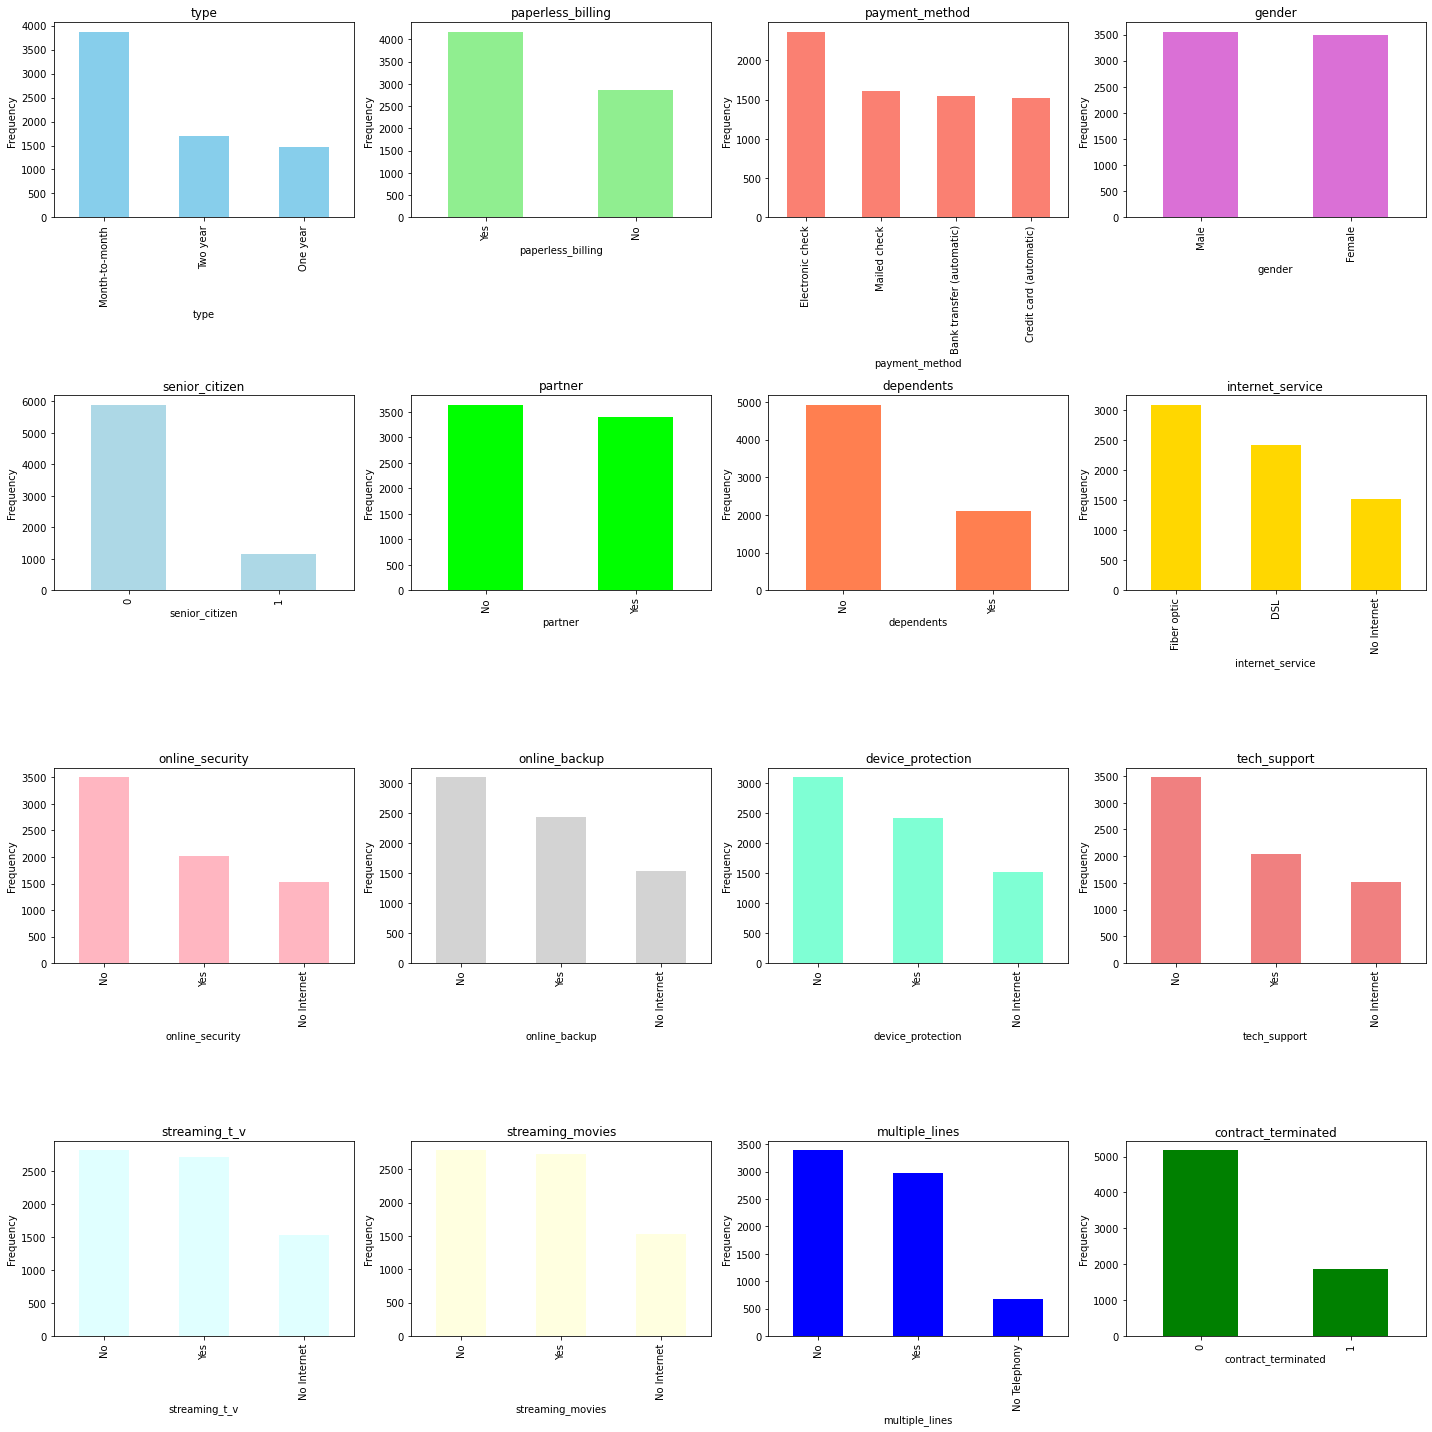

In [60]:
# Список колонок для построения графиков
columns_to_plot = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
                  'partner', 'dependents', 'internet_service', 'online_security', 'online_backup',
                  'device_protection', 'tech_support', 'streaming_t_v',
                  'streaming_movies', 'multiple_lines', 'contract_terminated']
titles = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
                  'partner', 'dependents', 'internet_service', 'online_security', 'online_backup',
                  'device_protection', 'tech_support', 'streaming_t_v',
                  'streaming_movies', 'multiple_lines', 'contract_terminated']
colors = ['skyblue', 'lightgreen', 'salmon', 'orchid', 'lightblue', 'lime', 'coral', 'gold',
          'lightpink', 'lightgray', 'aquamarine', 'lightcoral', 'lightcyan', 'lightyellow', 'blue', 'green']

# Настройка фигуры и подграфиков
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Цикл для создания столбчатых диаграмм
for ax, column, title, color in zip(axes.flatten(), columns_to_plot, titles, colors):
    data[column].value_counts().plot(kind='bar', ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Распределение значений осталось прежним, но теперь мы видим и количество пользователей, у которых не подключены интернет или телефония.

Целевой признак 'contract_terminated' не сбалансирован. Большинство клиентов (более 5000) не разорвали договора, менее 2000 клиентов - разорвали.

Для числовых значений построим гистограммы.

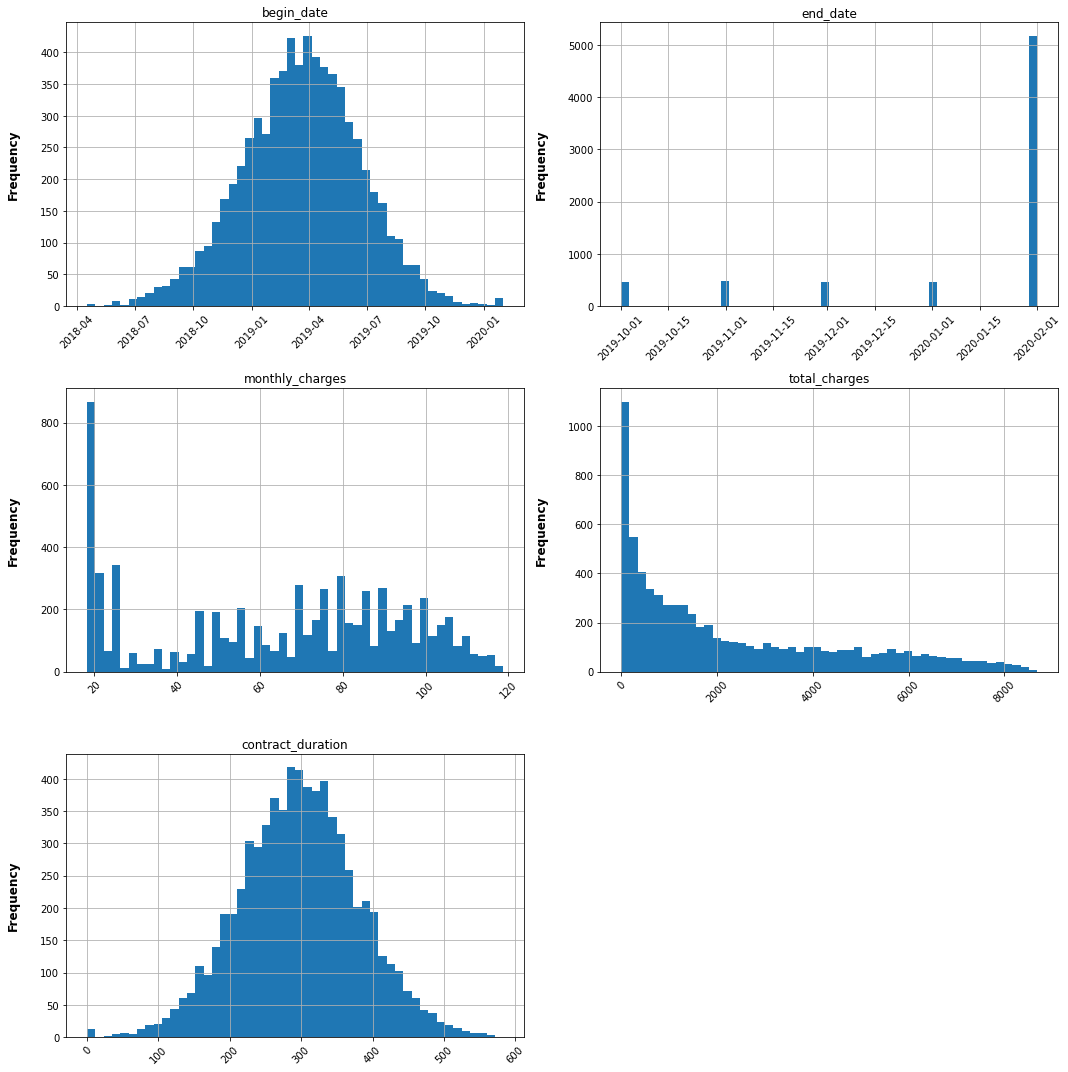

In [61]:
col = ['begin_date', 'end_date', 'monthly_charges', 'total_charges', 'contract_duration']

axes = data[col].hist(bins=50, figsize=(15, 15))

for ax in axes.flatten():
    ax.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

#Поворот меток по оси X под углом 45 градусов
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [62]:
num_col = ['monthly_charges', 'total_charges', 'contract_duration']
data[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
contract_duration,7043.0,297.378674,83.868181,0.00,242.00,298.00,351.00,583.00


Добавили новый признак - 'contract_duration' (длительность контракта в днях). В среднем договор длится около 297 дней.
Min  - 0 дней (совсем новые пользователи, которые подключились в день выгрузки базы), max - 583 дня.


Визуализирем соотношение ушедших и оставшихся клиентов для каждого признака.

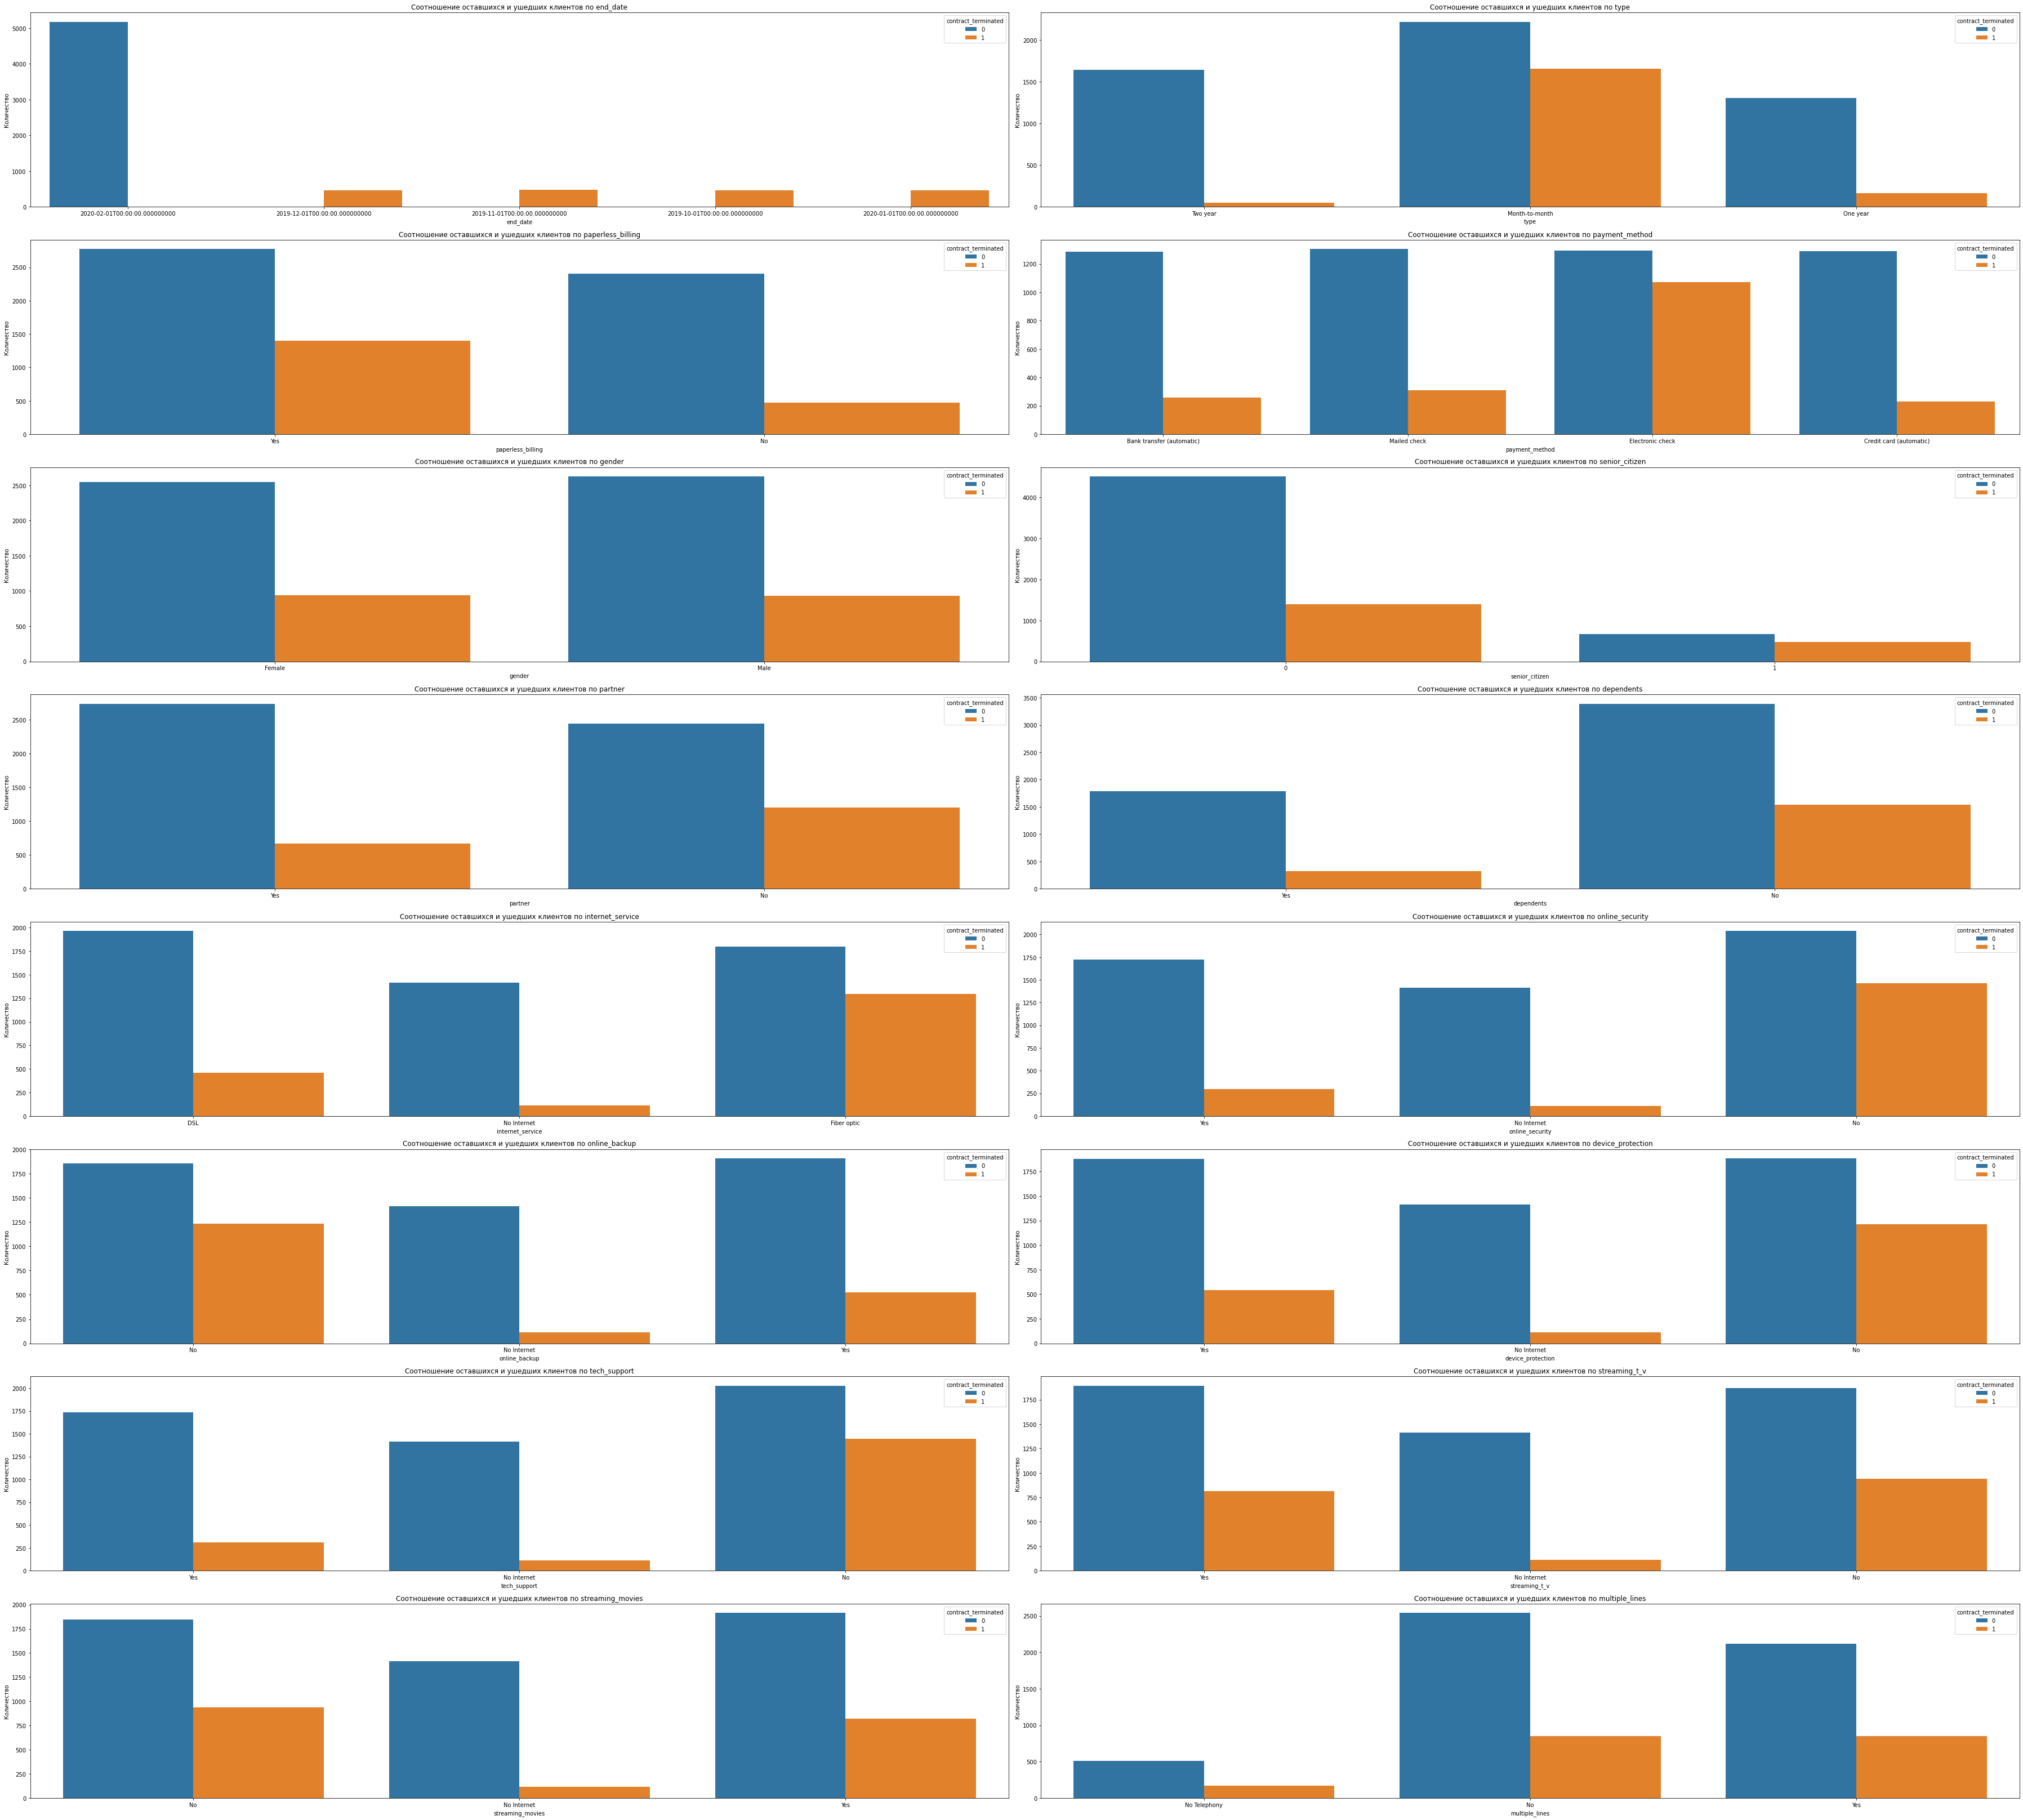

In [63]:
# Список колонок для построения графиков
columns_to_plot = [
    'end_date', 'type', 'paperless_billing', 'payment_method',
    'gender', 'senior_citizen', 'partner',
    'dependents', 'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies',
    'multiple_lines'
]

# Настройка фигуры и подграфиков
fig, axes = plt.subplots(8, 2, figsize=(50, 45))
axes = axes.flatten()

# Цикл для создания столбчатых диаграмм
for ax, column in zip(axes, columns_to_plot):
    sns.countplot(x=column, hue='contract_terminated', data=data, ax=ax)
    ax.set_title(f'Соотношение оставшихся и ушедших клиентов по {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Количество')

# Удаление пустых подграфиков
for ax in axes[len(columns_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

* Видим даты, когда клиенты закрывали договора 'end_date', они все приходятся на 2019 г: 2019-12-01, 2019-11-01, 2019-10-01.

* Примерно одинаковое количество мужчин и женщин закрывало договора. Гендерный признак 'gender' в нашем случае не коррелирует с целевым признаком.

* Довольно высокая вероятность разрыва договоров среди пенсионеров 'senior_citizen' и холостых клиентов 'partner' без детей 'dependents'.

* Чаще всего разрывают договор те, кто пользуется помесячной оплатой 'type', у кого есть электронный расчётный лист - 'paperless_billing' и кто платит електронными чеками 'payment_method'.

* Большое количество пользователей, разрывающих договор среди тех у кого подключены телефоны к нескольким линиям одновременно 'multiple_lines' и у кого не подключены.

* Большое количество пользователей, разрывающих договор и среди тех у кого подключены стриминговое телевидение 'streaming_t_v' и каталог фильмов 'streaming_movies' и у кого не подключены.

* Хоть большинство пользователей предпочитают подключение интернета через DSL, однако чаще закрывают договора клиенты, пользовавшиеся fiber optic ('internet_service').

* Чаще разрывают договора те клиенты, которые не пользовались техподдержкой 'tech_support', не подключали опцию блокировки опасных сайтов 'online_security', не подключали антивирус 'device_protection' и не подключали облачное хранилище файлов для резервного копирования данны 'online_backup'.

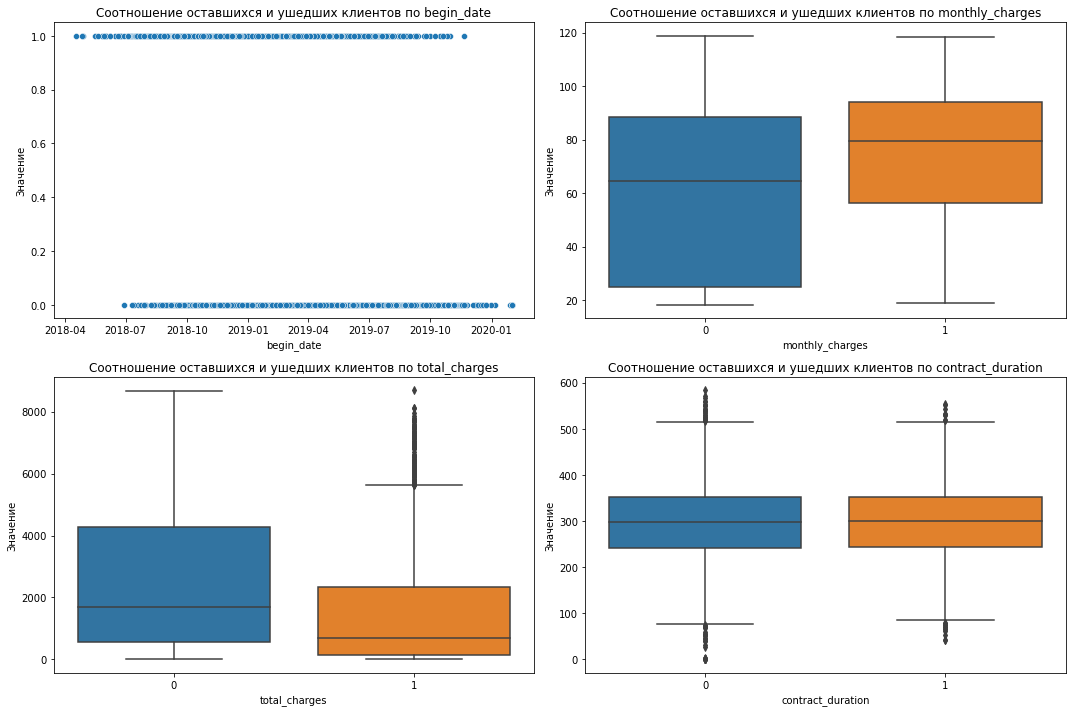

In [64]:
# Список колонок для построения графиков
columns_to_plot = ['begin_date', 'monthly_charges', 'total_charges', 'contract_duration']

# Настройка фигуры и подграфиков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Цикл для создания графиков
for ax, column in zip(axes, columns_to_plot):
    if column == 'begin_date':
        sns.scatterplot(x=column, y='contract_terminated', data=data, ax=ax)
    else:
        sns.boxplot(x='contract_terminated', y=column, data=data, ax=ax)
    ax.set_title(f'Соотношение оставшихся и ушедших клиентов по {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Значение')

plt.tight_layout()
plt.show()

* Сложно установить связь между датой начала заключения договора 'begin_date' и фактом его разрыва. Можно лишь отметить, что те, кто заключал договор до 2018-07 разорвали договор. И те кто заключал договор в период  2019-10 - 2020-01 не разорвали договор, но возможно, потому что прошло еще не так много времени.

* Ежемесячные траты 'monthly_charges' у тех, кто не разорвал договор ниже, и находятся в диапазоне (нижний и верхний квартиль) - 25-90 с медианой 65.
В то время, как у тех, кто разрывал контракт ежемесячные траты были выше:  верхний и нижний квартиль 55-95 с медианой 80.

* Однако общие траты 'total_charges' у тех кто не разорвал договр а выше, чем у тех, кто разорвал. Нижний и верхний квартиль у таких клиентов в диапазоне 500-4250 с медианой 1900.
У тех, кто разрывал договор диапазон 100-2100 с медианой 250.

* Длительность контракта 'contract_duration' (в днях) примерно одинаковая и для тех кто разорвал договор и для тех, кто нет. Нижний и верхний квартиль 250-350 дней, медианное значение - 300. дней

Выберите признаки, которые будете использовать для обучения, учитывайте особенности данных и выбранных моделей. Перед вами не стоит задача временных рядов, поэтому не стоит использовать даты как входные признаки модели.

Если вы сгенерируете новый признак «Длительность контракта абонента», то не используйте его одновременно с любыми другими производными признака BeginDate — например с годом заключения договора. Это приведёт к утечке целевого признака.

Проведем корреляционный анализ.

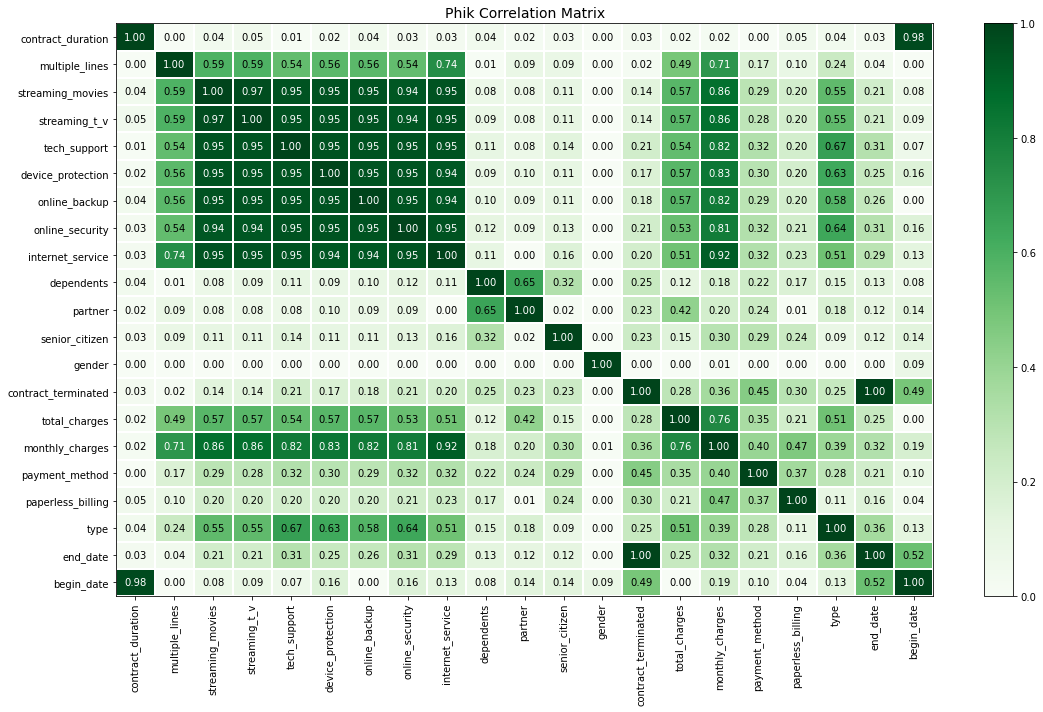

In [65]:
# Создание копии датафрейма и удаление колонки customer_id
data_copy = data.copy()
data_copy.drop(columns=['customer_id'], inplace=True)

# Указание интервальных колонок
interval_columns = ['monthly_charges', 'total_charges', 'contract_duration']

# Расчет корреляционной матрицы phik с указанием интервальных колонок
phik_overview = data_copy.phik_matrix(interval_cols=interval_columns)
phik_overview = phik_overview.round(2)

# Построение корреляционной матрицы
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Phik Correlation Matrix",
                        fontsize_factor=1,
                        figsize=(16, 10))
plt.tight_layout()
plt.show()

* Наблюдается сильная корреляция между категориальными/бинарными признаками, относящимися к интернет услугам: 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'internet_service'.

* Также есть сильная корреляция между количественным признаком 'monthly_charges' и бинарными: 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'internet_service'

* А также между 'contract_duration' и begin_date и между 'contract_terminated' и end_date.

Удалим 'monthly_charges' так как это числовой признак и он сильно коррелирует с другими.

Для бинарных или номинальных данных (категории) использование корреляционных методов, предназначенных для количественных данных, может привести к некорректным или малоинформативным результатам.
Однако удалим 'gender', 'contract_duration', 'multiple_lines', 'streaming_movies', 'streaming_t_v' - так как мы выяснили при анализе данных, что эти признаки не влияют на то, разорвал ли клмент договор или нет - при наличии этих признаков, пропорция 0/1 примерно одинаковая.

Удалим также 'customer_id', 'begin_date', 'end_date'.

In [66]:
data = data.drop(['customer_id', 'begin_date', 'end_date', 'monthly_charges', 'gender', 'contract_duration',
                 'multiple_lines', 'streaming_movies', 'streaming_t_v'], axis=1)
data.head()

,type,paperless_billing,payment_method,total_charges,contract_terminated,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support
0,Two year,Yes,Bank transfer (automatic),0.00,0,0,Yes,Yes,DSL,Yes,No,Yes,Yes
1,Two year,No,Mailed check,0.00,0,0,No,Yes,No Internet,No Internet,No Internet,No Internet,No Internet
2,Month-to-month,Yes,Mailed check,108.15,1,0,No,No,DSL,Yes,Yes,No,No
3,Two year,No,Mailed check,0.00,0,0,Yes,Yes,DSL,Yes,Yes,Yes,No
4,Month-to-month,Yes,Electronic check,151.65,1,0,No,No,Fiber optic,No,No,No,No


После удаления ненужных колонок проверим датасет еще раз на дубли.

In [67]:
data.duplicated().sum()

47

In [68]:
# Удалим дубликаты
data.drop_duplicates(inplace=True, ignore_index=True)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6996 entries, 0 to 6995
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 6996 non-null   object 
 1   paperless_billing    6996 non-null   object 
 2   payment_method       6996 non-null   object 
 3   total_charges        6996 non-null   float64
 4   contract_terminated  6996 non-null   int64  
 5   senior_citizen       6996 non-null   int64  
 6   partner              6996 non-null   object 
 7   dependents           6996 non-null   object 
 8   internet_service     6996 non-null   object 
 9   online_security      6996 non-null   object 
 10  online_backup        6996 non-null   object 
 11  device_protection    6996 non-null   object 
 12  tech_support         6996 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 710.7+ KB


In [70]:
# Итоговые признаки, которые берем на этап обучения моделей
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'total_charges',
       'contract_terminated', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support'],
      dtype='object')

Таким образом у нас осталось 13 признаков и 6996 клиентов.
Эти данные берем для дальнейшего обучения моделей.

In [71]:
data.to_csv('data.csv', index=False)

In [75]:
data = pd.read_csv('data.csv')
data.head()

,type,paperless_billing,payment_method,total_charges,contract_terminated,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support
0,Two year,Yes,Bank transfer (automatic),0.00,0,0,Yes,Yes,DSL,Yes,No,Yes,Yes
1,Two year,No,Mailed check,0.00,0,0,No,Yes,No Internet,No Internet,No Internet,No Internet,No Internet
2,Month-to-month,Yes,Mailed check,108.15,1,0,No,No,DSL,Yes,Yes,No,No
3,Two year,No,Mailed check,0.00,0,0,Yes,Yes,DSL,Yes,Yes,Yes,No
4,Month-to-month,Yes,Electronic check,151.65,1,0,No,No,Fiber optic,No,No,No,No


## Вывод

На этапе исследовательского анализа и предобработки данных

* **Выгрузили из базы данных 4 таблицы:**

    * contract — информация о договорах;
    * personal — персональные данные клиентов;
    * internet — информация об интернет-услугах;
    * phone — информация об услугах телефонии.

* Проанализировали исходные данные. Проверили данные на наличие пропусков, явных дубликатов, аномалий.
Изучили распределение признаков.

* Обработали аномалии с учётом особенностей услуг телекоммуникации.

* Исправили типы данных.

* Объединили таблицы по ID клиента.
  
* Сгенерировали новый признак: длительность контракта абонента в днях - 'contract_duration'.

* Выделили в **целевую переменную** признак EndDate - **'contract terminated'** (разорвал ли клиент договор 0 - нет, 1 - да)

* Провели исследовательский анализ данных объединённой таблицы,  заполнили пропуски и визуализировали распределение каждого признака:

    * У большинства клиентов тип интернет-подключения 'internet_service' - fiber optic.
    * Большинство клиентов не подключали опцию блокировка опасных сайтов 'online_security'.
    * Большинство клиентов не подключали опцию - облачное хранилище файлов для резервного копирования данных 'online_backup'
    * Большинство клиентов не подключали опцию антивирус 'device_protection'
    * Большинство клиентов не подключали опцию выделенная линия технической поддержки 'tech_support'
    * Примерно одинаковое количество клиентов пользуются/не пользуются стриминговым телевидением 'streaming_t_v'
    * Примерно одинаковое количество клиентов пользуются/не пользуются каталогом фильмов 'streaming_movies'
    * Новый признак - 'contract_duration' (длительность контракта в днях). В среднем договор длится около 297 дней. Min - 0 дней (совсем новые пользователи, которые подключились в день выгрузки базы), max - 583 дня.
    * Целевой признак 'contract_terminated' не сбалансирован. Большинство клиентов (более 5000) не разорвали договора, менее 2000 клиентов - разорвали.


* Визуализировали соотношение ушедших и оставшихся клиентов для каждого признака:

    * Видим даты, когда клиенты закрывали договора 'end_date', они все приходятся на 2019 г: 2019-12-01, 2019-11-01, 2019-10-01.

    * Примерно одинаковое количество мужчин и женщин закрывало договора. Гендерный признак 'gender' в нашем случае не коррелирует с целевым признаком.

    * Довольно высокая вероятность разрыва договоров среди пенсионеров 'senior_citizen' и холостых клиентов 'partner' без детей 'dependents'.

    * Чаще всего разрывают договор те, кто пользуется помесячной оплатой 'type', у кого есть электронный расчётный лист - 'paperless_billing' и кто платит електронными чеками 'payment_method'.

    * Большое количество пользователей, разрывающих договор среди тех у кого подключены телефоны к нескольким линиям одновременно 'multiple_lines' и у кого не подключены.

    * Большое количество пользователей, разрывающих договор и среди тех у кого подключены стриминговое телевидение 'streaming_t_v' и каталог фильмов 'streaming_movies' и у кого не подключены.

    * Хоть большинство пользователей предпочитают подключение интернета через DSL, однако чаще закрывают договора клиенты, пользовавшиеся fiber optic ('internet_service').

    * Чаще разрывают договора те клиенты, которые не пользовались техподдержкой 'tech_support', не подключали опцию блокировки опасных сайтов 'online_security', не подключали антивирус 'device_protection' и не подключали облачное хранилище файлов для резервного копирования данны 'online_backup'.

    * Сложно установить связь между датой начала заключения договора 'begin_date' и фактом его разрыва. Можно лишь отметить, что те, кто заключал договор до 2018-07 разорвали договор. И те кто заключал договор в период 2019-10 - 2020-01 не разорвали договор, но возможно, потому что прошло еще не так много времени.

    * Ежемесячные траты 'monthly_charges' у тех, кто не разорвал договор ниже, и находятся в диапазоне (нижний и верхний квартиль) - 25-90 с медианой 65. В то время, как у тех, кто разрывал контракт ежемесячные траты были выше: верхний и нижний квартиль 55-95 с медианой 80.

    * Однако общие траты 'total_charges' у тех кто не разорвал договр а выше, чем у тех, кто разорвал. Нижний и верхний квартиль у таких клиентов в диапазоне 500-4250 с медианой 1900. У тех, кто разрывал договор диапазон 100-2100 с медианой 250.

    * Длительность контракта 'contract_duration' (в днях) примерно одинаковая и для тех кто разорвал договор и для тех, кто нет. Нижний и верхний квартиль 250-350 дней, медианное значение - 300. дней


* Провели корреляционный анализ:

    * Наблюдается сильная корреляция между категориальными/бинарными признаками, относящимися к интернет услугам: 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'internet_service'.

    * Также есть сильная корреляция между количественным признаком 'monthly_charges' и бинарными: 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'internet_service'

    * А также между 'contract_duration' и begin_date и между 'contract_terminated' и end_date.

    Удалять бинарные/категориальные признаки мы не будем. Для бинарных (0/1) или номинальных данных (категории) использование корреляционных методов, предназначенных для количественных данных, может привести к некорректным или малоинформативным результатам.

    * Удалили признаки: 'begin_date', 'end_date', 'monthly_charges', 'customer_id', 'gender'.

Таким образом у нас осталось 13 признаков и 6996 клиентов. Эти данные берем для дальнейшего обучения моделей:

'type', 'paperless_billing', 'payment_method', 'total_charges', 'contract_terminated', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support'.








# Подготовка данных к обучению. Обучение моделей

Подготовьте данные для обучения:
  
Разделите данные на тренировочную и тестовую выборки (test_size = 0.25).
Подготовьте выборки для обучения, учитывайте особенности выбранных моделей.

Рассмотрите классы моделей:
- решающее дерево или случайный лес,
- бустинги,
- нейронные сети.

Найдите лучшую модель для прогноза оттока клиентов. Оцените её качество метрикой **ROC-AUC**. Выберите лучшую модель по значению метрики на кросс-валидации.

Подберите значения как минимум двум гиперпараметрам хотя бы для одной модели. Лучше всего использовать методы автоматизированного подбора гиперпараметров: GridSearchCV, RandomizedSearchCV, OptunaSearchCV, Optuna и другие.

Цель нашего проекта: разработать модель, которая сможет предсказывать, разорвёт ли абонент договор
Целевая переменная 'contract_terminated' (0 - не разорвет, 1 - разорвет)

Перед нами задача классификации.  

Разделим датасет на тренировочную и тестовые выборки.

Обучим модели на тренировочных данных:  

* RandomForestClassifier
* CatBoostClassifier
* LGBMClassifier

In [76]:
# Выделим целевой признак
X = data.drop('contract_terminated', axis=1)
y = data['contract_terminated']

In [77]:
# Выделим категориальные и числовые столбцы для обработки
categorical_cols = ['type', 'payment_method', 'paperless_billing',
                    'senior_citizen', 'partner', 
                    'dependents', 'internet_service', 'online_security',
                    'online_backup', 'device_protection', 'tech_support']

numerical_cols = ['total_charges']

Разделим модель на обучающую и тестовую выборки (test_size = 0.25).
Добавим параметр stratify, чтобы отношение данных целевого признака в подвыборках было одинаковым. Это важно, так как наша целевая переменная 'contract_terminated' несбалансирована.

In [78]:
# разделим модель на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5247, 12) (1749, 12) (5247,) (1749,)


В нашем исследовании не будем отдельно балансировать тренировочную выборку, так как планируем использовать кросс-валидацию GridSearchCV.
Дело в том, что для одной и той же модели оценка метрики качества на сбалансированной выборке гораздо выше, чем на несбалансированной. Если обучать объект GridSearchCV на сбалансированной обучающей выборке, в процессе кросс-валидации она будет разделена на несколько фолдов, из которых будут выделены валидационные и обучающие. И эти валидационные фолды тоже будут сбалансироваными. И как следствие, мы получим завышенные метрики и рискуем выбрать не самую лучшую модель и гиперпараметры.

Поэтому лучше отказаться от балансировки.

Обучим выбранные модели на тренировочных данных.
Оценивать качество моделей будем метрикой **ROC-AUC**.

## Обучение моделей

### RandomForestClassifier

In [79]:
# Создадим DataFrame для хранения результатов тестирования моделей
results = pd.DataFrame(columns=['Model', 'ROC-AUC'])

In [80]:
# Обработка категориальных признаков с помощью OrdinalEncoder
cat_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Обработка числовых данных с помощью StandardScaler
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [81]:
# Компоновка обработчиков признаков
col_transf = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numerical_cols),
    ('cat_pipeline', cat_pipeline, categorical_cols)
], n_jobs=-1)

# Инициализация модели RandomForestClassifier и компоновщика признаков в один конвейер
pipeline_rf = Pipeline([
    ('col_transf', col_transf),
    ('model_rf', RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE))
])

In [82]:
# Задание сетки параметров для подбора гиперпараметров RandomForestClassifier
param_rf = {
    'model_rf__n_estimators': [10, 50, 100],
    'model_rf__max_depth': [None, 3, 5, 8],
    'model_rf__min_samples_leaf': [1, 2, 4]
}

In [83]:
# Подбор лучших гиперпараметров с помощью GridSearchCV
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Получение лучших параметров и оценки ROC-AUC
best_params_rf = grid_rf.best_params_
score_rf = grid_rf.best_score_

print(f'\nЛучшие параметры RandomForestClassifier: {best_params_rf}')
print(f'Лучшая оценка ROC-AUC: {score_rf}')

# Добавление результатов в общую таблицу результатов
results = pd.concat([results, pd.DataFrame({
    'Model': ['RandomForestClassifier'],
    'ROC-AUC': [score_rf]
})], ignore_index=True)


Лучшие параметры RandomForestClassifier: {'model_rf__max_depth': 5, 'model_rf__min_samples_leaf': 2, 'model_rf__n_estimators': 100}
Лучшая оценка ROC-AUC: 0.8359938220007461


### CatBoostClassifier

In [84]:
# Получим индексы категориальных признаков
categorical_cols_idx = [X_train.columns.get_loc(col) for col in categorical_cols]

# Создадим модель CatBoostClassifier с указанием индексов категориальных признаков
catboost_model = CatBoostClassifier(cat_features=categorical_cols_idx, random_state=RANDOM_STATE)

In [85]:
param_catboost = {
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'iterations': [50, 100, 150, 200],
    'l2_leaf_reg': [1, 3, 5, 8]
}

grid_catboost = GridSearchCV(catboost_model, param_grid=param_catboost, cv=5,
                       n_jobs=-1, scoring='roc_auc')

grid_catboost.fit(X_train, y_train)

best_params_catboost = grid_catboost.best_params_
score_catboost = grid_catboost.best_score_

print(f'\nЛучшие параметры CatBoostClassifier: {best_params_catboost}')
print(f'Лучшая оценка ROC-AUC: {score_catboost}')

results = pd.concat([results, pd.DataFrame({
    'Model': ['CatBoostClassifier'],
    'ROC-AUC': [score_catboost]
})], ignore_index=True)

0:	learn: 0.6647525	total: 69.5ms	remaining: 6.88s
1:	learn: 0.6411648	total: 83.5ms	remaining: 4.09s
2:	learn: 0.6207454	total: 86.1ms	remaining: 2.78s
3:	learn: 0.6046739	total: 89.5ms	remaining: 2.15s
4:	learn: 0.5817083	total: 91.9ms	remaining: 1.75s
5:	learn: 0.5624623	total: 94.1ms	remaining: 1.47s
6:	learn: 0.5448052	total: 96.3ms	remaining: 1.28s
7:	learn: 0.5314754	total: 99.5ms	remaining: 1.14s
8:	learn: 0.5210811	total: 103ms	remaining: 1.04s
9:	learn: 0.5118662	total: 106ms	remaining: 953ms
10:	learn: 0.5016699	total: 108ms	remaining: 872ms
11:	learn: 0.4920912	total: 110ms	remaining: 806ms
12:	learn: 0.4833407	total: 112ms	remaining: 748ms
13:	learn: 0.4762849	total: 114ms	remaining: 698ms
14:	learn: 0.4701015	total: 116ms	remaining: 657ms
15:	learn: 0.4645266	total: 121ms	remaining: 634ms
16:	learn: 0.4600196	total: 124ms	remaining: 606ms
17:	learn: 0.4564882	total: 127ms	remaining: 580ms
18:	learn: 0.4530926	total: 129ms	remaining: 550ms
19:	learn: 0.4492467	total: 131ms

### LGBMClassifier

In [86]:
cat_pipeline = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)

num_pipeline = make_pipeline(
    StandardScaler()
)

col_transf = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numerical_cols),
    ('cat_pipeline', cat_pipeline, categorical_cols)
], n_jobs=-1)

lgbm_model = LGBMClassifier(random_state=RANDOM_STATE)

pipeline_lgbm = Pipeline(
    steps=[
        ('col_transf', col_transf),
        ('model_lgbm', lgbm_model)
    ]
)

param_lgbm = {
    'model_lgbm__learning_rate': [0.1, 0.2, 0.3, 0.5],
    'model_lgbm__max_depth': [4, 6, 8, 10],
    'model_lgbm__n_estimators': [10, 20, 50, 100, 150, 200],
    'model_lgbm__reg_alpha': [0.1, 1.0],
    'model_lgbm__reg_lambda': [0.1, 1.0],
    'model_lgbm__num_leaves': [10, 20]
}

grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid=param_lgbm, cv=5,
                         n_jobs=-1, scoring='roc_auc')

grid_lgbm.fit(X_train, y_train)

best_params_lgbm = grid_lgbm.best_params_
score_lgbm = grid_lgbm.best_score_

print(f'\nЛучшие параметры LGBMClassifier: {best_params_lgbm}')
print(f'Лучшая оценка ROC-AUC: {score_lgbm}')

results = pd.concat([results, pd.DataFrame({
    'Model': ['LGBMClassifier'],
    'ROC-AUC': [score_lgbm]
})], ignore_index=True)

[LightGBM] [Info] Number of positive: 1385, number of negative: 3862
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 5247, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263960 -> initscore=-1.025485
[LightGBM] [Info] Start training from score -1.025485

Лучшие параметры LGBMClassifier: {'model_lgbm__learning_rate': 0.2, 'model_lgbm__max_depth': 4, 'model_lgbm__n_estimators': 20, 'model_lgbm__num_leaves': 10, 'model_lgbm__reg_alpha': 0.1, 'model_lgbm__reg_lambda': 0.1}
Лучшая оценка ROC-AUC: 0.8416715551104911


### Выбор лучшей модели

In [87]:
# Выведем результаты обучения моделей
results

,Model,ROC-AUC
0,RandomForestClassifier,0.835994
1,CatBoostClassifier,0.842515
2,LGBMClassifier,0.841672


Все модели дали примерно одинаковый результат.
Модель CatBoostClassifier показала чуть более лучший результатметрика качества ROC-AUC 0.842515.

Эту модель берем для предсказаний на тестовой выборке.

### Вывод

На этапе подготовки данных к обучению:

* Разделили датасет на тренировочную и тестовые выборки. Разделим модель на обучающую и тестовую выборки (test_size = 0.25). Добавим параметр stratify, чтобы отношение данных целевого признака в подвыборках было одинаковым. Это важно, так как наша целевая переменная 'contract_terminated' несбалансирована.

* Выбрали модели для обучения на тренировочных данных:

    * RandomForestClassifier
    * CatBoostClassifier
    * LGBMClassifier

* Обучили выбранные модели на тренировочных данных.
* Оценивали качество моделей метрикой ROC-AUC.

* Получили результаты обучения со следующими показателями ROC-AUC:
    * RandomForestClassifier	0.835994
    * CatBoostClassifier	0.842515
    * LGBMClassifier	0.841672

* Все модели дали примерно одинаковый результат. Модель CatBoostClassifier показала чуть более лучший результат, метрика качества ROC-AUC 0.8425:
    * 'depth': 4,
    * 'iterations': 100,
    * 'l2_leaf_reg': 3,
    * 'learning_rate': 0.1

Эту модель берем для предсказаний на тестовой выборке.

## Обучение лучшей модели и предсказание на тестовой выборке

* Проверьте качество лучшей модели на тестовой выборке. Значение метрики ROC-AUC должно быть не менее 0.85.
Для интерпретируемости модели дополнительно выведите значение accuracy.

* Постройте матрицу ошибок лучшей модели. Отобразите полноту и точность модели на графике.

* Проанализируйте важность основных входных признаков, влияющих на отток клиентов.

* Для одного из важных входных признаков проведите дополнительное исследование:
Покажите график зависимости входного и целевого признаков.

In [89]:
# Обучим модель с лучшими гиперпараметрами
best_catboost_model = grid_catboost.best_estimator_

# Предскажем на тестовой выборке вероятности
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]

# Предскажем на тестовой выборке классы
y_pred = best_catboost_model.predict(X_test)

# Расчет ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Расчет accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'ROC-AUC на тестовой выборке: {roc_auc}')
print(f'Accuracy на тестовой выборке: {accuracy}')

ROC-AUC на тестовой выборке: 0.8511506177496935
Accuracy на тестовой выборке: 0.8038879359634077


* Проверили качество лучшей модели CatBoostClassifier на тестовой выборке. Получили значение **ROC-AUC 0.8511**, что отвечает требованиям задачи (значение метрики ROC-AUC должно быть не менее 0.85). Это означает, что в 85.1% случаев модель правильно различает положительные (отток) и отрицательные (нет оттока) классы.

* Для интерпретируемости модели дополнительно получили значение **Accuracy 0.8039**. Accuracy измеряет долю правильных предсказаний (классов 1 и 0) от общего числа предсказаний. В нашем случае это означает, что 80.4% всех предсказаний модели были верными.

Дополнительно построим ROC-кривую (Receiver Operating Characteristic Curve) - график для оценки качества бинарного классификатора.

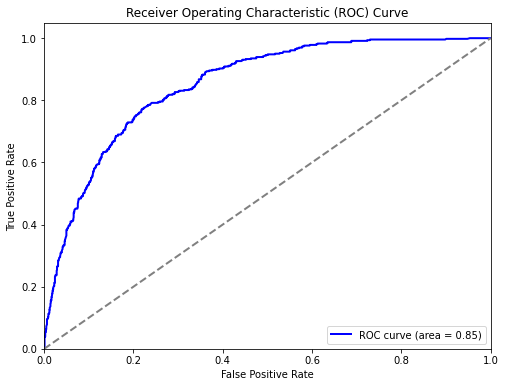

In [90]:
# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Кривая ROC показывает соотношение TPR (True Positive Rate) и FPR (False Positive Rate) при различных порогах классификации.
Кривая, близкая к верхнему левому углу, указывает на высокое качество модели. У нас это значение 0.85 из 1, что является хорошим показателем.

## Матрица ошибок лучшей модели

Дополнительно построим матрицу ошибок лучшей модели.

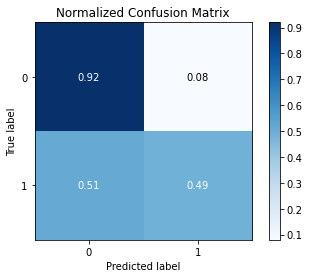

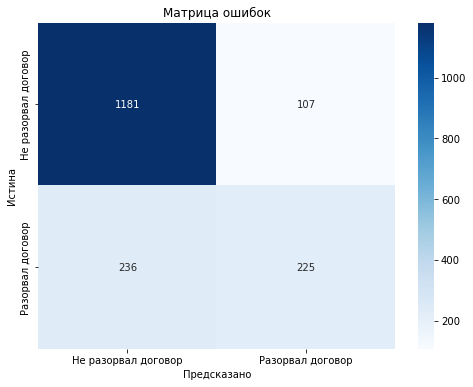

In [91]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Не разорвал договор', 'Разорвал договор'],
            yticklabels=['Не разорвал договор', 'Разорвал договор'])
plt.xlabel('Предсказано')
plt.ylabel('Истина')
plt.title('Матрица ошибок')
plt.show()

Согласно матрице ошибок показатель True Positives (TP) довольно высок, это означает, что наша модель в 92% случаев верно предсказывает что клиент не разорвет договор, модель ошибается в данном случае только на 8%.

Что касается оценки True Negatives (TN), тут модель только в 49% правильно определяет отток клиентов, ошибается в 51% случаев.

Учитывая эту информацию, наша модель не столь эффективна, так как для клиента критичнее получать предсказания того, что клиент разорвет договор.



Отобразим график полноты и точности модели.

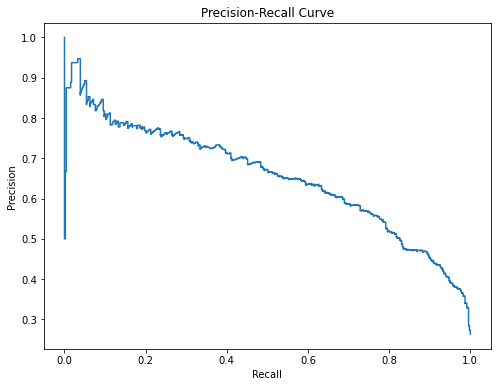

In [92]:
# Получим вероятность класса 1
probs = best_catboost_model.predict_proba(X_test)[:, 1]

# Вычислим precision и recall
precision, recall, _ = precision_recall_curve(y_test, probs)

# Построим кривую precision-recall
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.gcf().set_size_inches(8, 6)
plt.title('Precision-Recall Curve')
plt.show()

Линия спускается по мере увеличения recall, что указывает на то, что часть положительных объектов класса 1 была правильно определена, но вместе с тем уменьшается точность (precision). Это означает, что при увеличении recall модель делает больше ошибок и классифицирует некоторые негативные объекты как положительные.

Когда recall достигает 1 (все положительные объекты были правильно определены), precision уменьшается до 0.25, что означает, что среди всех объектов, которые модель предсказала как положительные, только 25% действительно принадлежат к классу 1. Это довольно низкий показатель.

## Анализ важности входных признаков

Проанализируем важность основных входных признаков, влияющих на отток клиентов.

Top 10 важных признаков:
              Feature  Importance
7    internet_service   30.439826
3       total_charges   24.373435
0                type   19.565611
8     online_security    6.588852
1   paperless_billing    6.585575
2      payment_method    3.827409
11       tech_support    3.313852
4      senior_citizen    1.870555
9       online_backup    1.782018
6          dependents    1.603884


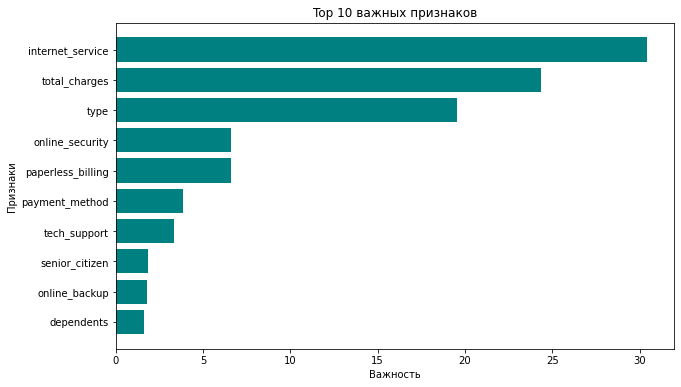

In [93]:
# Извлечение модели catboost из пайплайна
if hasattr(best_catboost_model, 'named_steps'):
    catboost_model = best_catboost_model.named_steps['model_lgbm']
else:
    catboost_model = best_catboost_model

# Вычисление важности признаков
feature_importance = catboost_model.feature_importances_

# Создадим DataFrame
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Отсортируем признаки по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выведем топ-10 важных признаков
top_n = 10
print(f'Top {top_n} важных признаков:')
print(importance_df.head(top_n))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n], color='teal')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Top 10 важных признаков')
plt.gca().invert_yaxis()
plt.show()

Наиболее важными признаками, оказавшими влияние на предсказание оттока клиентов, являются:

1. internet_service   - 30.439826
2. total_charges  - 24.373435
3. type  - 19.565611
4. online_security  -  6.588852
5. paperless_billing  -  6.585575
6. payment_method  -  3.827409
7. tech_support  -  3.313852
8. senior_citizen  -  1.870555
9. online_backup  -  1.782018
10. dependents  -  1.603884

## График зависимости самого важного фактора и целевой переменной

Построим график зависимости входного (internet_service) и целевого признаков (contract_terminated).

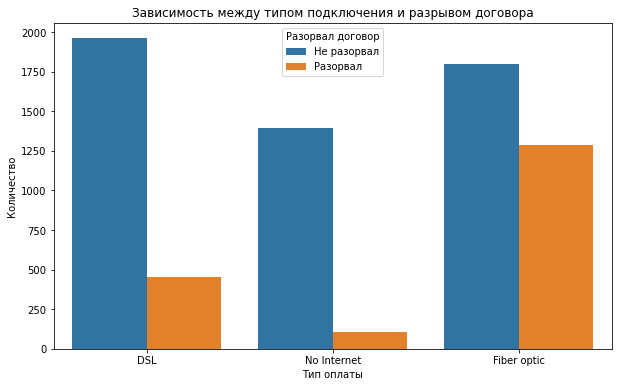

In [94]:
plt.figure(figsize=(10, 6))
sns.countplot(x='internet_service', hue='contract_terminated', data=data)
plt.title('Зависимость между типом подключения и разрывом договора')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество')
plt.legend(title='Разорвал договор', labels=['Не разорвал', 'Разорвал'])
plt.show()

На графике видим, что клиенты, использующие подключение интернета fiber optic гораздо чаще разрывают договора, чем клиенты с другим подключением или без интернет-подключения.

Дополнительно проверим лучшую модель на адекватность с помощью константной модели DummyClassifier

In [95]:
# Создадим константную модель, предсказывающий наиболее часто встречающийся класс
dummy_model = DummyClassifier(strategy="most_frequent")

# Обучим константную модель
dummy_model.fit(X_train, y_train)

# Предскажем на тестовой выборке
y_pred_dummy = dummy_model.predict(X_test)

roc_auc_dummy = roc_auc_score(y_test, dummy_model.predict_proba(X_test)[:, 1])
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

print(f'ROC-AUC константной модели: {roc_auc_dummy}')
print(f'Accuracy константной модели: {accuracy_dummy}')

ROC-AUC константной модели: 0.5
Accuracy константной модели: 0.73642081189251


ROC-AUC константной модели DummyClassifier 0.5, что ниже результата тестирования нашей лучшей модели на тестовой выборке. Это говорит об адекватности выбранной нами модели.

## Вывод

* Для поиска лучшей модели, предсказывающий отток клиентов, были протестированы:

    * RandomForestClassifier
    * CatBoostClassifier
    * LGBMClassifier

* Были получены результаты обучения со следующими показателями ROC-AUC:

    * RandomForestClassifier	0.835994
    * CatBoostClassifier	0.842515
    * LGBMClassifier	0.841672

* Модель CatBoostClassifier показала чуть более лучший результат, метрика качества ROC-AUC 0.848442. Лучшие гиперпараметры:

    * 'depth': 4,
    * 'iterations': 100,
    * 'l2_leaf_reg': 3,
    * 'learning_rate': 0.1

Эту модель брали для предсказаний на тестовой выборке.

* Проверили качество лучшей модели CatBoostClassifier на тестовой выборке. Получили значение **ROC-AUC 0.8511**, что отвечает требованиям задачи (значение метрики ROC-AUC должно быть не менее 0.85). Это означает, что в 85.1% случаев модель правильно различает положительные (отток) и отрицательные (нет оттока) классы.

* Для интерпретируемости модели дополнительно получили значение **Accuracy 0.8039**. Accuracy измеряет долю правильных предсказаний (классов 1 и 0) от общего числа предсказаний. В нашем случае это означает, что 80.4% всех предсказаний модели были верными.

* Построили Матрицу ошибок. Показатель True Positives (TP) довольно высок, это означает, что наша модель в 91% случаев верно предсказывает, что клиент не разорвет договор, модель ошибается в данном случае только на 9%. Что касается оценки True Negatives (TN), тут модель только в 49% правильно определяет отток клиентов, ошибается в 51% случаев.

* Построили график полноты и точности модели.
Линия на графике спускается по мере увеличения recall, что указывает на то, что часть положительных объектов класса 1 была правильно определена, но вместе с тем уменьшается точность (precision). Это означает, что при увеличении recall модель делает больше ошибок и классифицирует некоторые негативные объекты как положительные.
Когда recall достигает 1 (все положительные объекты были правильно определены), precision уменьшается до 0.25, что означает, что среди всех объектов, которые модель предсказала как положительные, только 25% действительно принадлежат к классу 1.

* Проанализировали важность основных входных признаков, влияющих на отток клиентов.
Наиболее важными признаками, оказавшими влияние на предсказание оттока клиентов, являются:

1. internet_service   - 30.439826
2. total_charges  - 24.373435
3. type  - 19.565611
4. online_security  -  6.588852
5. paperless_billing  -  6.585575
6. payment_method  -  3.827409
7. tech_support  -  3.313852
8. senior_citizen  -  1.870555
9. online_backup  -  1.782018
10. dependents  -  1.603884

* Построили график зависимости входного признака (internet_service) и целевого (contract_terminated).
На графике видим, что клиенты, использующие подключение интернета fiber optic гораздо чаще разрывают договора, чем клиенты с другим подключением или без интернет-подключения.

Учитывая всю информацию, наша итоговая модель не столь эффективна, так как нам важнее получать предсказания того, что клиент разорвет договор. Однако наша модель делает довольно много ошибок в предсказании класса 1.

Это связано с тем, что у нас изначально довольно мало данных о клиентах, разорвавших договор (дисбаланс классов в целевом признаке).

В качестве рекомендаций улучшения модели и предсказания класса 1 можно попробовать:

* Запросить у клиента больше исторических данных о клиентах, разорвавших договор и попробовать обучить модели снова.
* Можно попробовать совместить балансировку с кросс-валидацией (SMOTE, RanomOverSampler/RanomUnderSampler).
* Создать новые признаки на основе имеющихся данных


В качестве бизнес-рекомендаций, основанных на исследовании и работы модели, заказчику можно предложить:

* Разработать и внедрить персонализированные предложения для клиентов, которые с высокой вероятностью могут разорвать договор. Это могут быть скидки, специальные условия или улучшенные тарифы.
* Оптимизировать предложения на основе сегментации клиентов по ключевым признакам (например, тип оплаты, наличие дополнительных услуг).
* Внедрить системы проактивного обслуживания клиентов, которая будет автоматически связываться с клиентами с высоким риском оттока и предлагать им помощь или дополнительные услуги.
* Улучить обратную связь с клиентами для выяснения причин недовольства и устранение этих причин.
* Разработать программы лояльности для удержания клиентов, таких как бонусные программы, накопительные скидки или эксклюзивные предложения для долгосрочных клиентов.
* Обновить и улучшить тарифные планы и дополнительные услуги, чтобы они лучше соответствовали потребностям клиентов.



## Проверка модели на новых данных

In [101]:
# Сохранение модели в формате pickle
with open('best_catboost_model.pkl', 'wb') as f:
    pickle.dump(best_catboost_model, f)

In [102]:
# Загрузка модели из файла pickle
with open('best_catboost_model.pkl', 'rb') as f:
    best_catboost_model = pickle.load(f)

In [108]:
# Новые данные
new_data = pd.DataFrame({
    'type': ['Two year'],
    'paperless_billing': ['No'],
    'payment_method': ['Mailed check'],
    'total_charges': [220],
    'senior_citizen': [0],
    'partner': ['Yes'], 
    'dependents':['Yes'],
    'internet_service': ['No Internet'],
    'online_security': ['No Internet'],
    'online_backup': ['No Internet'],
    'device_protection': ['No Internet'],
    'tech_support': ['No Internet']
    
})

In [109]:
# Предсказание
predictions = best_catboost_model.predict(new_data)

# Вывод результатов
print("Predicted customer churn:", predictions)

Predicted customer churn: [0]


## Тест API

In [111]:
import requests

def predict_model(data):
    url = 'http://127.0.0.1:8000/predict_model'

    # Отправка POST-запроса с данными в формате форм-данных
    response = requests.post(url, json=data)

    # Проверка статуса ответа
    if response.status_code == 200:
        return response.json()
    else:
        return {"error": f"Request failed with status code {response.status_code}"}

# Пример данных для предсказания
data = {
    "type": "Two year",
    "paperless_billing": "No",
    "payment_method": "Mailed check",
    "total_charges": 220,
    "senior_citizen": 0,
    "partner": "Yes", 
    "dependents": "Yes",
    "internet_service": "No Internet",
    "online_security": "No Internet",
    "online_backup": "No Internet",
    "device_protection": "No Internet",
    "tech_support": "No Internet"
}

# Получение предсказания
prediction = predict_model(data)
print(prediction)

{'prediction': 'Not Contract Terminated'}
